## Background Information
You are a quantitative researcher working with a commodity trading desk. Alex, a VP on the desk, wants to start trading natural gas storage contracts. However, the available market data must be of higher quality to enable the instrument to be priced accurately. They have sent you an email asking you to help extrapolate the data available from external feeds to provide more granularity, considering seasonal trends in the price as it relates to months in the year. To price the contract, we will need historical data and an estimate of the future gas price at any date.

Commodity storage contracts represent deals between warehouse (storage) owners and participants in the supply chain (refineries, transporters, distributors, etc.). The deal is typically an agreement to store an agreed quantity of any physical commodity (oil, natural gas, agriculture) in a warehouse for a specified amount of time. The key terms of such contracts (e.g., periodic fees for storage, limits on withdrawals/injections of a commodity) are agreed upon inception of the contract between the warehouse owner and the client. The injection date is when the commodity is purchased and stored, and the withdrawal date is when the commodity is withdrawn from storage and sold. 

A client could be anyone who would fall within the commodities supply chain, such as producers, refiners, transporters, and distributors. This group would also include firms (commodities trading, hedge funds, etc.) whose primary aim is to take advantage of seasonal or intra-day price differentials in physical commodities. For example, if a firm is looking to buy physical natural gas during summer and sell it in winter, it would take advantage of the seasonal price differential mentioned above. The firm would need to leverage the services of an underground storage facility to store the purchased inventory to realize any profits from this strategy.

## Problem

After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df = pd.read_csv("Nat_Gas.csv", parse_dates=["Dates"])
df = df.set_index("Dates")
df

,Prices
Dates,
2020-10-31,10.10
2020-11-30,10.30
2020-12-31,11.00
2021-01-31,10.90
2021-02-28,10.90
2021-03-31,10.90
2021-04-30,10.40
2021-05-31,9.84
2021-06-30,10.00


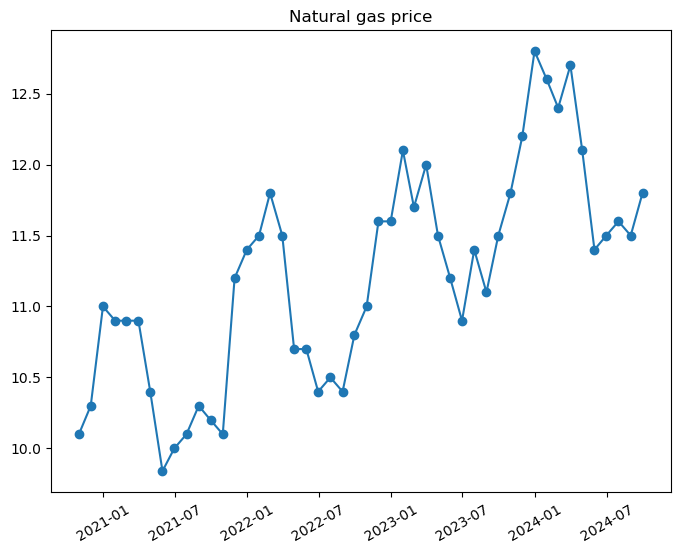

In [3]:
figure(figsize=(8, 6))
plt.plot(df.index, df["Prices"])
plt.scatter(df.index, df["Prices"])
plt.xticks(rotation=30)
plt.title("Natural gas price")
plt.show()

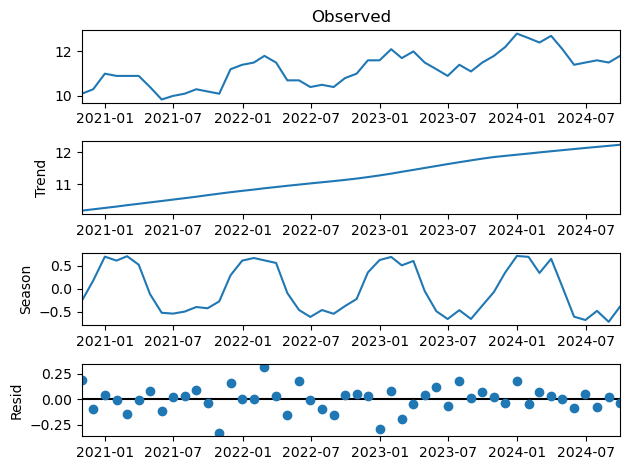

In [4]:
stl = STL(df)
res = stl.fit()
fig = res.plot()

From performing STL decomposition, we can clearly see that there is an upwards trend and seasonal component to the natural gas price.

The seasonal cycle is every 12 months, as we can see that there is a spike in price around January and a drop around July.

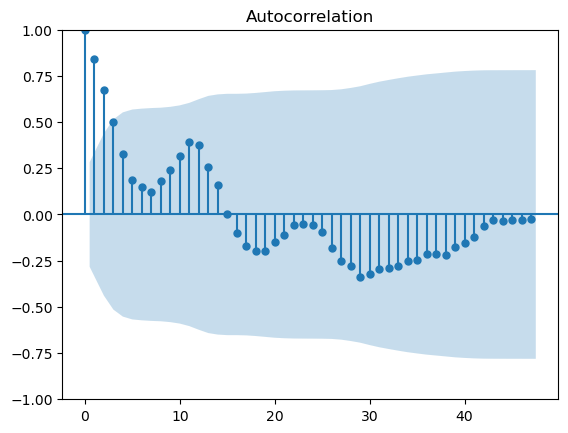

In [5]:
plot_acf(df, lags=len(df)-1);

c:\Users\ROG ZEPHYRUS\miniconda3\envs\mds574\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


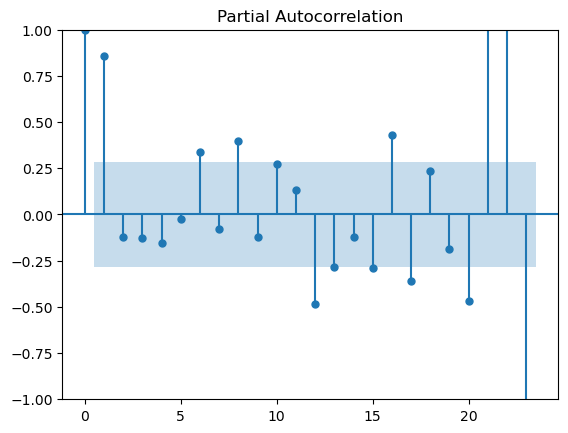

In [6]:
plot_pacf(df, lags=len(df)/2 - 1);

We fit the data using an additive ARIMA model with a seasonal component of 12 months. From here, we can extrapolate the future values using this model.

In [7]:
stlf = STLForecast(df, ARIMA, model_kwargs={"order": (1, 1, 0), "seasonal_order": (1, 1, 0, 12), "freq": "M"})
model = stlf.fit()

c:\Users\ROG ZEPHYRUS\miniconda3\envs\mds574\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [8]:
forecasts = model.forecast(steps=12)
forecasts = pd.DataFrame(forecasts)
forecasts.columns = ["Prices"]
forecasts

,Prices
2024-10-31,12.305491
2024-11-30,12.642410
2024-12-31,12.918263
2025-01-31,13.141762
2025-02-28,12.690669
2025-03-31,13.133239
2025-04-30,12.652138
2025-05-31,12.092743
2025-06-30,11.966898
2025-07-31,12.372217


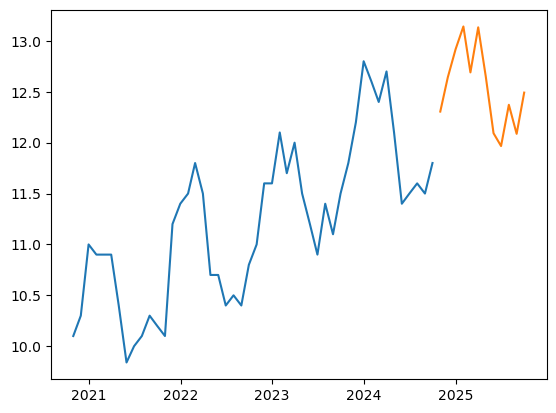

In [9]:
plt.plot(df)
plt.plot(forecasts)

In [10]:
combined_df = pd.concat([df, forecasts])
combined_df

,Prices
2020-10-31,10.100000
2020-11-30,10.300000
2020-12-31,11.000000
2021-01-31,10.900000
2021-02-28,10.900000
2021-03-31,10.900000
2021-04-30,10.400000
2021-05-31,9.840000
2021-06-30,10.000000
2021-07-31,10.100000


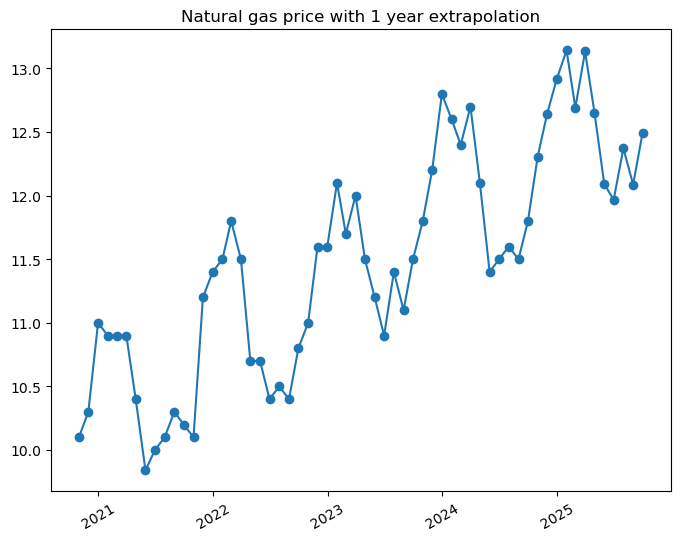

In [11]:
# plt.plot(combined_df)
figure(figsize=(8, 6))
plt.plot(combined_df)
plt.scatter(combined_df.index, combined_df["Prices"])
plt.xticks(rotation=30)
plt.title("Natural gas price with 1 year extrapolation")
plt.show()

In [12]:
def price_estimate(date, natural_gas_price_data):
    """
    Given a date, return the price of natural gas.
    :param date: str (in the form %Y-%m)
    :param natural_gas_price_data: pd.DataFrame
    :return: float
    """
    date_idx = natural_gas_price_data.index.strftime("%Y-%m").tolist()
    try:
        idx = date_idx.index(date)
        return natural_gas_price_data.iloc[idx].values[0]
    except ValueError:
        print(f"No predicted value for date: {date}")
        return -1

In [13]:
price_estimate("2025-01", combined_df)

13.141761946580656

In [14]:
price_estimate("2024-01", combined_df)

12.6

In [15]:
price_estimate("2025-05", combined_df)

12.092743393414736